# Leaky Integrate and fire model

$ I(t) = I_R + I_C \\
I(t) = \frac{V(t)-V_{Rest}}{R} +C\frac{\text{d}V}{\text{d}t} \\
\tau_m = RC$


final equation

$ \frac{\text{d}V}{\text{d}t} = \frac{V_{Rest}-V}{\tau_m } +\frac{R}{\tau_m }I \\
$

$V$ and $I$ are time dependent


Action potentials occur whenever the membrane potential $V$ of the model neuron reaches a threshold value $V_{th}$. After the action potential, the potential is reset to a value $V_{reset}$ below the threshold potential  ( $ V_{reset} < V_{th}$ ).

# Implementation

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.grid'] = True
mpl.rcParams[ 'grid.linewidth'] = 0.5
mpl.rcParams['font.sans-serif'] = [ 'Arial']
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
def dV(V, Input, dt, par_dict):
    '''
    Differential equation for membrane potential (V) before reaching the threshold
    where Input can also be a time dependent variable
    dV/dt=f(V, I, R, tau) --> dV=f()*dt
    '''
    tau_m = par_dict['tau_m']    #membrane time constant
    R_m = par_dict['R_m']        #resistance of membrane
    V_rest = par_dict['V_rest']  #resting potential
    
    
    return dt/tau_m*(R_m*Input + (V_rest-V))


Numerical method (Runge Kutta) to solve differential equation

In [3]:
def rk4(f, y, param, dt, par_dict):
    k1 = f(y, param, dt, par_dict)
    k2 = f(y + dt * k1 * 0.5, param, dt, par_dict)
    k3 = f(y + dt * k2 * 0.5, param, dt, par_dict)
    k4 = f(y + dt * k3, param, dt, par_dict)
    return (k1 + 2*k2 + 2*k3 + k4) / 6

def update(V, Input, dt, par_dict):
    V += rk4(dV, V, Input, dt, par_dict)
    return V

In [4]:
def plot_current(Time, Current, color="C0"):
    plt.subplots(figsize = [12,5])
    plt.xlabel('$t$ (ms)', fontsize=16)
    plt.ylabel('$I$ $\mathrm{(\mu A/cm^2)}$',fontsize=16)
    # plt.xlim(-1, 30)
    #plt.ylim(-2, 12)
    plt.plot(Time, Current)
    plt.title('Input Current $I$',fontsize=16)
    
def plot_membrane_potential(Time, Voltage, color = '#bd0026'):

    plt.subplots(figsize = [12,5])
    plt.xlabel('$t$ (ms)',fontsize=16)
    plt.ylabel('$V$ (mV)',fontsize=16)
    #plt.ylim(-20, 120)
    plt.plot(Time, Voltage, color)
    title = plt.title('Membrane Potential $V$',fontsize=16)

In [5]:
def run_simulation(
    ### simulation parameters ###
   
    dt = 0.01,      # time step (ms)
    T = 55,         # total running time (ms)
    V_start = -60,   # starting potential (mV)
    
    ### model paramters ###
    R_m = 10,          # membrane resistance  (Ohm)
    tau_m = 10,     # membrane time scale = RC  (ms)
    V_rest = -65,     # resting potential (mV)
    V_reset = -65,    # reset potential   (mV)
    V_th = -50,       # threshold potential (mv)
    V_spike = 40,     # membrane potential during action potential (mV)
    Input_strength=10, #membrane current during simulation
    noise_strength=1, #stength of noise in noisy input
    flag = 'spike'
    ):
    
    par_dict = dict(
        R_m=R_m,
        tau_m = tau_m,
        V_rest = V_rest,        
    )
    
    # initialize the simulation parameters
    V_m = V_start # membrane potential (mV)

    # total membrane current (microA/cm**2) for the time of the simulation   
    I_input = np.array([0] * (int(T/dt)), dtype="float32")
    if flag == 'spike':
        I_input[1500:1800] = Input_strength
    if flag == 'burst':
        I_input[1500:] = Input_strength
    if flag == 'long':
        I_input[1500:] = Input_strength        
    if flag == 'noisy':
        I_input[1500:] = Input_strength + np.random.randn(I_input[1500:].shape[0])*noise_strength
    Time = [ii*dt for ii in range(int(T/dt))]


    result_V_m=[] 
    result_V_m.append(V_m)
    
    for t in range(len(I_input)):
        V_m= update(V=V_m,Input=I_input[t], dt=dt, par_dict = par_dict)
        if V_m > V_th:
            result_V_m[-1]=V_spike             
            #if we exceed threshold, set step to spike value and reset potential
            V_m = V_reset
            
        result_V_m.append(V_m)
        #updates.append()
    return result_V_m[1:],  I_input, Time

## Run a simulation

This is how you run a very simple simulation. Between 15 and 18 ms, we pass an external Input to our model cell with a defined Input strength. 


What happens if you change the initial voltage (V_start) or the Input strength?


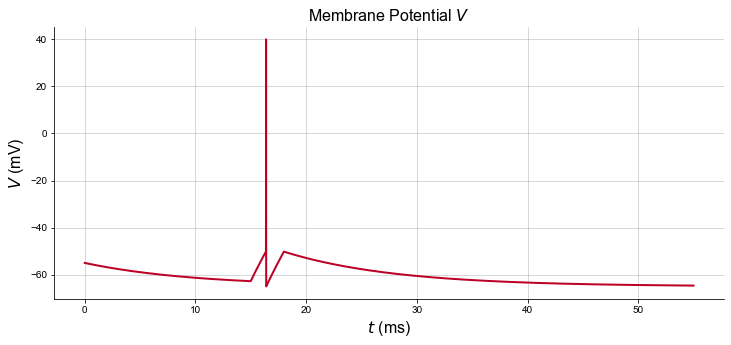

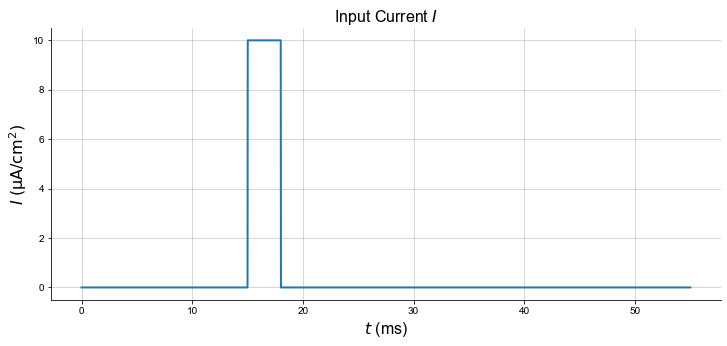

In [6]:
Voltage,I,Time = run_simulation(V_start=-55,                                 
                                Input_strength=10,
                                flag="spike", )
plot_membrane_potential(Time = Time, Voltage = Voltage)
plot_current(Time = Time, Current = I)

## Effect of varying input strength

Here, we systemtically increase the input strength (different colors). 
The higher the input strength, the faster (and more often) the neuron spikes.

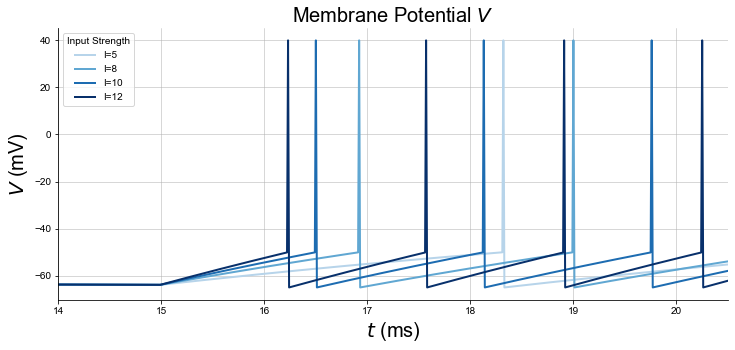

In [7]:
list_inputs=[5,8,10,12]
fig, axs = plt.subplots(1,1,figsize = [12,5])
colors = plt.cm.Blues(np.linspace(0.3,1,len(list_inputs)))
for color, Input_strength in zip(colors,[5,8,10,12]):
    V_membrane,Input,Time = run_simulation(Input_strength=Input_strength, 
                                          flag='long')
    axs.plot(Time, V_membrane, color = color, label = "I={}".format(Input_strength))
    
    
axs.set_xlabel('$t$ (ms)', fontsize=20)
axs.set_ylabel('$V$ (mV)', fontsize=20)
axs.set_xlim(xmax=20.5, xmin=14)
title = plt.title('Membrane Potential $V$', fontsize=20)
axs.legend(title = "Input Strength" )



Zoom out, to see that the frequency of spiking increases as input strength increases.

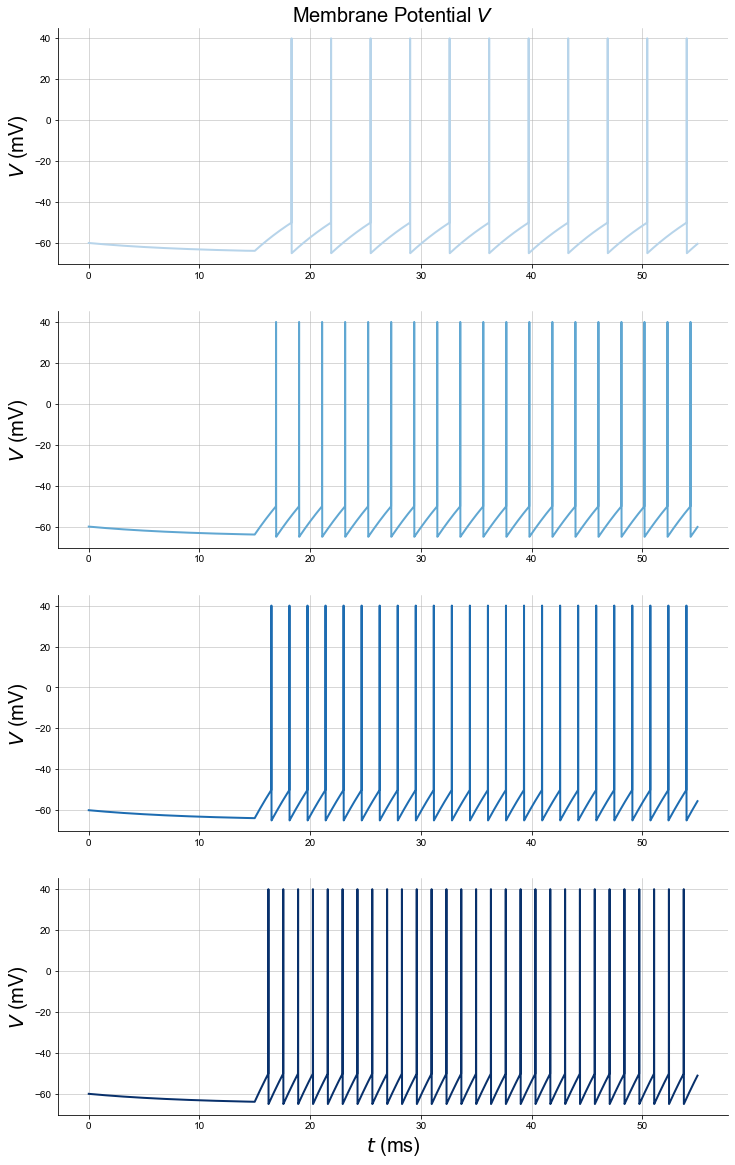

In [16]:
list_inputs=[5,8,10,12]
fig, axs = plt.subplots(4,1,figsize = [12,5*len(list_inputs)])
colors = plt.cm.Blues(np.linspace(0.3,1,len(list_inputs)))
for idx_sim, (color, Input_strength) in enumerate(zip(colors,[5,8,10,12])):
    V_membrane,Input,Time = run_simulation(Input_strength=Input_strength, 
                                          flag='long')
    ax=axs[idx_sim]
    ax.plot(Time, V_membrane, color = color, label = "I={}".format(Input_strength))
    if idx_sim==len(list_inputs)-1: ax.set_xlabel('$t$ (ms)', fontsize=20)
    ax.set_ylabel('$V$ (mV)', fontsize=20)
    if idx_sim==0: ax.set_title('Membrane Potential $V$', fontsize=20)

## Noisy Input

What happens if we add noise to the system?

Here, we add additional noise to a deterministic input (results shown in red).

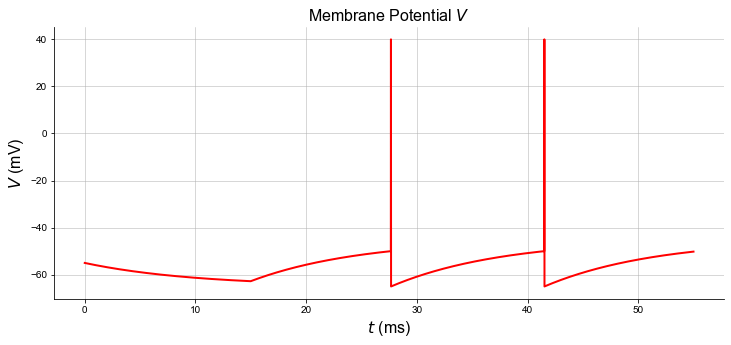

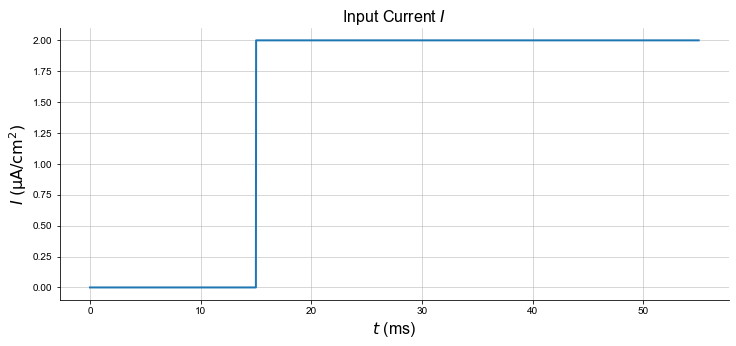

In [9]:
Voltage,I,Time = run_simulation(V_start=-55, flag="noisy",
                               Input_strength=2,
                               noise_strength=0)
plot_membrane_potential(Time = Time, Voltage = Voltage, color="r")
plot_current(Time = Time, Current = I)

Now we show a simulation where (white) noise is added to the input (see below). How does the response timing change?

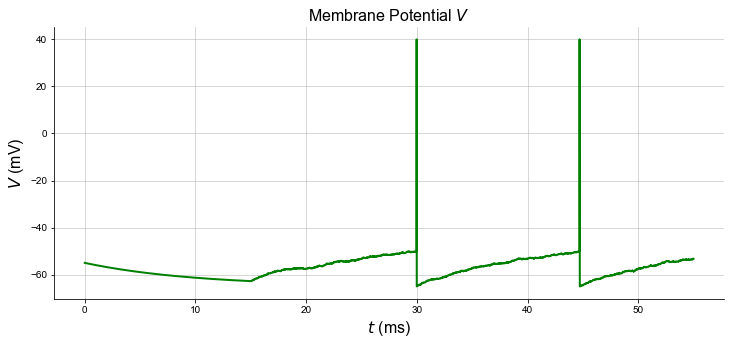

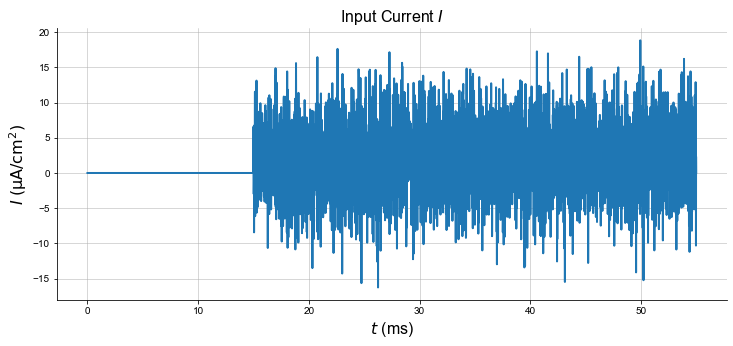

In [10]:
Voltage,I,Time = run_simulation(V_start=-55, flag="noisy",
                               Input_strength=2,
                               noise_strength=5)
plot_membrane_potential(Time = Time, Voltage = Voltage, color="g")
plot_current(Time = Time, Current = I)

Let's repeat for more simulations! What do you expect?

Text(0.5, 1.0, 'Membrane Potential $V$')

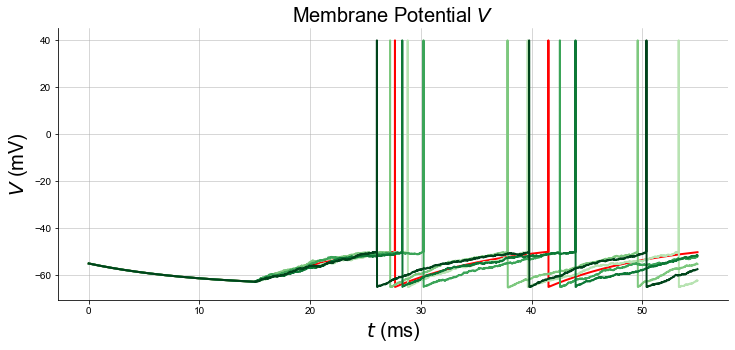

In [14]:

Nrep=5
fig, axs = plt.subplots(1,1,figsize = [12,5])
colors = plt.cm.Greens(np.linspace(0.3,1,Nrep))
#noise free, deterministic
Voltage,I,Time = run_simulation(V_start=-55, flag="noisy", 
                                Input_strength=2,
                               noise_strength=0)
axs.plot(Time, Voltage, color = "r",)
for idx_rep in range(Nrep):
    Voltage,I,Time = run_simulation(V_start=-55, flag="noisy", 
                                Input_strength=2,
                               noise_strength=5)
    axs.plot(Time, Voltage, color = colors[idx_rep],)

axs.set_xlabel('$t$ (ms)', fontsize=20)
axs.set_ylabel('$V$ (mV)', fontsize=20)
axs.set_title('Membrane Potential $V$', fontsize=20)

Zoom in: The noise in the input influences the trajectory until the threshold is reached.

(14.0, 35.0)

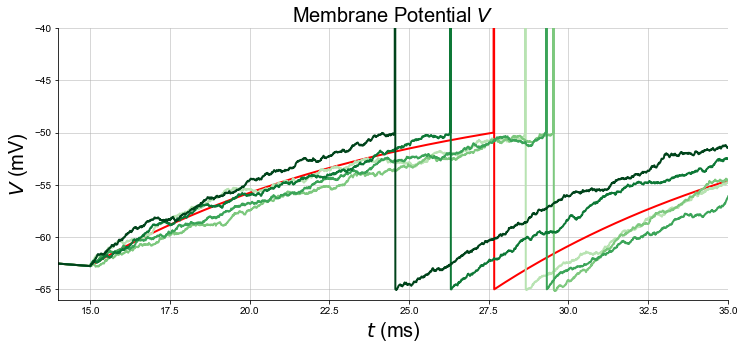

In [13]:
Nrep=5
fig, axs = plt.subplots(1,1,figsize = [12,5])
colors = plt.cm.Greens(np.linspace(0.3,1,Nrep))
#noise free simulation
Voltage,I,Time = run_simulation(V_start=-55, flag="noisy", 
                                Input_strength=2,
                               noise_strength=0)
axs.plot(Time, Voltage, color = "r",)
for idx_rep in range(Nrep):
    Voltage,I,Time = run_simulation(V_start=-55, flag="noisy", 
                                Input_strength=2,
                               noise_strength=5)
    axs.plot(Time, Voltage, color = colors[idx_rep],)

axs.set_xlabel('$t$ (ms)', fontsize=20)
axs.set_ylabel('$V$ (mV)', fontsize=20)
axs.set_title('Membrane Potential $V$', fontsize=20)
axs.set_ylim(ymin=-66, ymax=-40)
axs.set_xlim(xmin=14, xmax=35)